# 🦾  Treat it as a project.
Yeah. I saw an introduction and this dataset looks amazing. This time, we are going to be dealing with a **new** dataset if the **human** activity.

This will be a new kind of problem that we will be trying to solve. Here, the dataset includes the "measurements" taken from the smart watch ⌚ from multiple people throughout the day.

> The goal is to classify **whether** a person is *sitting*, *dancing*, *sleeping* or whatever! Or just bathing in his bathtub. There will be 6 classes to classify. Hence, it is a **multiclass-classification** problem. But, with the time-series.


There are `2` sensors are used for this dataset: 
1. Gyroscope
2. Accelerometer

Each of them returns `3` separate channels because we are living in the 3D space.

___
Dataset metadata:
- There are 2 sensors,.
- Each will return 3 channels.
- Hence, we will be having `3` + `3` = **`6`** features.
- Their names are ***"acceleration"*** & ***"angular velocity"*** returned by accelerometer and gyroscope respectively.
- BUTT: There are **2** types of acceleration:
    1. Total acceleration
    2. Body acceleration = Total acceleration - gravity
- Hence, we have `3` + `3` + `3` = **`9`** final features in the dataset.

About the time-series:

- Each measurement was sampled at `50Hz` = 50 measurements/sec
- Taken at the intervals of `2.56` seconds.
- Thus, we have 50 * 2.56 = `128` measurements for each time-series.
- Meaning, **the leanght** of time series corresponding to **each** activity is 128.

Some pre-processing is done already:

- Noise removal
- Low pass filtering (smoothing - EWMA *if you remember* 😉)
- Scaling [-1, 1]

Hence, the time-series is not in a raw version.

      +--------+
      /        /|
     /    T   / |
    +--------+  |
    |        | D|
    |   N    |  +
    |        | /
    |        |/
    +--------+

Where:
- N: Number of observations
- T: Features
- D: What makes the feature? (128 observations)

Till now, this is the visualization of the data till now. And what about **Y**? It is the simple `1D` data encoded in {0, 1, 2, 3, 4, 5, 6}

#### 🤔 Does this look... a bit strange?
Yes, because till now... we have only worked with the **2D** data. Or just NxT data. Now are are dealing with **Multivariate** data.

Before this, we had **Univariate** data, thus we were able to store them in the 2D table. Here still a 2D table will be there, but the data itself has to be treated *differently*.

> Here are the links [link-1](https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones) or [link-2](https://www.kaggle.com/datasets/erenaktas/human-activity-recognition) to the dataset. Have a look if there is any confusion... or anything.

## 🛣 Side track

**A multi-variate jargon** <br>
So, till now we have seen the 2D data like...

#### 👉 Before
<img src="../images/univariate.jpg" width=300 height=300>

Where, <br>
- **N** is the number of observations.
- **T** is the number of features.

Such a simple and beautiful thing. <br>
____

#### 👉 Now
<img src="../images/multivariate.jpg" width=300 height=300>

Where, <br>
- **D** is the number of different perspectives to observe the data.

### 🐼 But in pandas...
We can show that like this.

In [1]:
import pandas as pd
import numpy as np

In [2]:
columns = pd.MultiIndex.from_product([["Machine 1", "Machine 2", "Machine 3"], 
                                      ["Height", "Weight"]])

In [3]:
np.random.seed(42)
df = pd.DataFrame(np.random.randint(-10, 10, (5, 3 * 2)), columns=columns)
df = pd.concat([df, pd.Series(
                np.random.choice(["M", "F"], 5),
                name=("", "Gender"))], 
          axis=1)

df.columns.names = ["D →", "T →"]
df.index.name = "N ↓"
df

D → Machine 1        Machine 2        Machine 3              
T →    Height Weight    Height Weight    Height Weight Gender
N ↓                                                          
0          -4      9         4      0        -3     -4      M
1           8      0         0     -7        -3     -8      M
2          -9      1        -5     -9       -10      1      M
3           1      6        -1      5         4      4      M
4           8      1         9     -8        -6      8      F

Yeah. This is it. This is the `N x T x D` shape.

*If you want to see some crazy things...* look below.

The data is like:

In [4]:
multivariate = np.arange(24).reshape(4, 2, 3)
multivariate

array([[[ 0,  1,  2],
        [ 3,  4,  5]],

       [[ 6,  7,  8],
        [ 9, 10, 11]],

       [[12, 13, 14],
        [15, 16, 17]],

       [[18, 19, 20],
        [21, 22, 23]]])

Here `3` levels are there. Meaning, 3 `Ds` are there.

In [5]:
# N x T x D
multivariate.shape

(4, 2, 3)

In [6]:
# first level
multivariate[:, :, 0]

array([[ 0,  3],
       [ 6,  9],
       [12, 15],
       [18, 21]])

In [7]:
# second level
multivariate[:, :, 1]

array([[ 1,  4],
       [ 7, 10],
       [13, 16],
       [19, 22]])

In [8]:
# third level
multivariate[:, :, 2]

array([[ 2,  5],
       [ 8, 11],
       [14, 17],
       [20, 23]])

To convert **that** into the dataframe style...

#### Option 1

In [9]:
# a reshape with order "F"
multivariate.reshape(4, 6, order="F")

array([[ 0,  3,  1,  4,  2,  5],
       [ 6,  9,  7, 10,  8, 11],
       [12, 15, 13, 16, 14, 17],
       [18, 21, 19, 22, 20, 23]])

#### Option 2

In [10]:
# a loop operation
x = multivariate[:, :, 0].copy()
for i in range(1, multivariate.shape[-1]): # for shape D
    x = np.c_[x, multivariate[:, :, i]]

In [11]:
x

array([[ 0,  3,  1,  4,  2,  5],
       [ 6,  9,  7, 10,  8, 11],
       [12, 15, 13, 16, 14, 17],
       [18, 21, 19, 22, 20, 23]])

#### 🛣 Back to the track

Now we know **how the data is represented** we would love to see **what shouldn't be done.**

## 🧷 What we did.

1. We had `N x T x D` shape of data.
2. We converted that into `N x TD` data so that can be treated as 2D

After that, the **naive approach** would be to **make the simple NN as we usually do**... 

```python
input_layer = Input(shape=(TD,))
hidden_layer = Dense(...)
...
model = Model(...)
```

Simple right? <br>
But that's **NOT** ideal. Because that means that: ***each dimension is treated equally.***

Since this time-series has a special structure, we would need to take the advantage of that. And also our neural network is so flexible that it can handle this *multivariate* or *multi-input* kind of inputs. We just need to tweak some parameters. 

### ⚒ So we will build multi "tailed" network

<img src="../images/multivariate-nn.png" width=400 height=500>

> 🤔 But...? Why multi **tailed** and not **multi-headed**? <br> <br> 😀 The reason is that, the final layer (output layer) is called the "head" of the neural net. Thus, the inputs are the tails.

And **yes**. The final layer (output layer) can have the multiple layers as well! Which is multi-layer-output.

The code will be like:
```python
# multiple inputes
input_layer1 = Input(shape(T,))
input_layer2 = Input(shape(T,))
input_layer3 = Input(shape(T,))

# hidden layer 1 for each inputs
hidden_layer1_1 = Dense(32, activation="relu")(input_layer1)
hidden_layer1_2 = Dense(32, activation="relu")(input_layer2)
hidden_layer1_3 = Dense(32, activation="relu")(input_layer3)

# this will let us to streamline all seperate layers into a single - sequential layer
full_layer = Concatenate()([hidden_layer1_1, hidden_layer1_2, hidden_layer1_3])

# the final output | K = number of classes (so the nodes)
output_layer = Dense(K)(full_layer)

# the model
model = Model([input_layer1, input_layer2, input_layer3], output_layer)
```

Yes, the code certainly feels like **training multiple seperate neural networks** for each layer... but that is just in the starting portion. When we concatenate, things are not like the *seperate nets*. 

# 

# 👨‍💻 Let's code it

In [40]:
# usual imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# unusual imports
import os

plt.rcParams["figure.figsize"] = (20, 10)

# sklearn imports
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import StandardScaler

# neural network imports
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate ### ← new ← ###
from tensorflow.keras.models import Model

# the neural network loss import
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# to save the model state: "મસ્ત"
from tensorflow.keras.callbacks import ModelCheckpoint

tf.random.set_seed(42)

> Please download the data from this direct [link](https://lazyprogrammer.me/course_files/timeseries/UCI-HAR.zip).

**NOTE**: The data is in **multiple** files. We have to merge all files together and make the single dataframe out of it.

___

## 📜  Some info about the dataset if you want to read.

The experiments have been carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities (*WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING*) wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, we captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz. The experiments have been video-recorded to label the data manually. The obtained dataset has been randomly partitioned into two sets, where 70% of the volunteers was selected for generating the training data and 30% the test data. 

The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used. From each window, a vector of features was obtained by calculating variables from the time and frequency domain. See 'features_info.txt' for more details. 

#### 👉 For each record it is provided:
- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration.
- Triaxial Angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 
- An identifier of the subject who carried out the experiment.

#### 👉 The dataset includes the following files:

- **'README.txt'**
- **'features_info.txt'**: Shows information about the variables used on the feature vector.
- **'features.txt'**: List of all features.
- **'activity_labels.txt'**: Links the class labels with their activity name.
- **'train/X_train.txt'**: Training set.
- **'train/y_train.txt'**: Training labels.
- **'test/X_test.txt'**: Test set.
- **'test/y_test.txt'**: Test labels.

The following files are available for the train and test data. Their descriptions are equivalent. 

- **'train/subject_train.txt'**: Each row identifies the subject who performed the activity for each window sample. Its range is from 1 to 30. 
- **'train/Inertial Signals/total_acc_x_train.txt'**: The acceleration signal from the smartphone accelerometer X axis in standard gravity units 'g'. Every row shows a 128 element vector. The same description applies for the 'total_acc_x_train.txt' and 'total_acc_z_train.txt' files for the Y and Z axis. 
- **'train/Inertial Signals/body_acc_x_train.txt'**: The body acceleration signal obtained by subtracting the gravity from the total acceleration. 
- **'train/Inertial Signals/body_gyro_x_train.txt'**: The angular velocity vector measured by the gyroscope for each window sample. The units are radians/second. 

#### 👉 Notes: 
- Features are normalized and bounded within [-1,1].
- Each feature vector is a row on the text file.
- The units used for the accelerations (total and body) are 'g's (gravity of earth -> 9.80665 m/seg2).
- The gyroscope units are rad/seg.
- A video of the experiment including an example of the 6 recorded activities with one of the participants can be seen in the following link: http://www.youtube.com/watch?v=XOEN9W05_4A

#### 👉 Activity lables:
- `1`  WALKING
- `2`  WALKING_UPSTAIRS
- `3`  WALKING_DOWNSTAIRS
- `4`  SITTING
- `5`  STANDING
- `6`  LAYING

___

Yeah, I have tried to make it look pretty... if you've read it, it should be pretty clear by now about the data. At least 20-30% what it tries to say.

Now, let's load the data in and see what's possible.

In [13]:
# this is the main data
!ls "../data/UCI-HAR/"

UCI HAR Dataset
__MACOSX


In [14]:
# this is the main view
!ls "../data/UCI-HAR/UCI HAR Dataset"

README.txt
activity_labels.txt
features.txt
features_info.txt
test
train


We're interested in `train` and `test`

In [15]:
# for `train`
!ls "../data/UCI-HAR/UCI HAR Dataset/train"

Inertial Signals
X_train.txt
subject_train.txt
y_train.txt


In [16]:
# for `test`
!ls "../data/UCI-HAR/UCI HAR Dataset/test"

Inertial Signals
X_test.txt
subject_test.txt
y_test.txt


👉 Before going inside of any of the files... let's have a look at `features.txt`

In [17]:
!head "../data/UCI-HAR/UCI HAR Dataset/features.txt"

1 tBodyAcc-mean()-X
2 tBodyAcc-mean()-Y
3 tBodyAcc-mean()-Z
4 tBodyAcc-std()-X
5 tBodyAcc-std()-Y
6 tBodyAcc-std()-Z
7 tBodyAcc-mad()-X
8 tBodyAcc-mad()-Y
9 tBodyAcc-mad()-Z
10 tBodyAcc-max()-X


There are like 561 features in total... but for the sake of *head* we can see these top 10.

Alright, <br>
Let's now explore the files in the `train` folder. Alternatively, the same type of data will be in the `test` folder. So, just try to understand.

In [18]:
# for `train`
!ls "../data/UCI-HAR/UCI HAR Dataset/train"

Inertial Signals
X_train.txt
subject_train.txt
y_train.txt


To start with, there is the `subject_train.txt` which is for...

In [19]:
!head "../data/UCI-HAR/UCI HAR Dataset/train/subject_train.txt"

1
1
1
1
1
1
1
1
1
1


In [20]:
# total number of records / lines
!wc -l "../data/UCI-HAR/UCI HAR Dataset/train/subject_train.txt"

7352 ../data/UCI-HAR/UCI HAR Dataset/train/subject_train.txt


There are total `30` people who contributed to this project... so this file represents the number from 1 to 30 to indecate which row represents what. **Which is not necessary** for our exploration and the model building.

In [21]:
# for `x_train`
Xtrain = pd.read_csv("../data/UCI-HAR/UCI HAR Dataset/train/X_train.txt", 
                        header=None, 
                        delim_whitespace=True)

In [22]:
Xtrain.head()

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


In [23]:
Xtrain.shape

(7352, 561)

Cool. This means that we have the data in `x_train` with columns as all the features **found in** the `features.txt` and the rows are different observations. *(Same as total number of lines in features.txt 7352 == 7352)*

In [24]:
# for `y_train`
!head "../data/UCI-HAR/UCI HAR Dataset/train/y_train.txt"

5
5
5
5
5
5
5
5
5
5


This shows the **activity**. Which is encoded from 1 to 5. 

In [25]:
!wc -l "../data/UCI-HAR/UCI HAR Dataset/train/y_train.txt"

7352 ../data/UCI-HAR/UCI HAR Dataset/train/y_train.txt


Again, the same number of records 7352  == 7352  == 7352 

In [26]:
!ls "../data/UCI-HAR/UCI HAR Dataset/train/Inertial Signals"

body_acc_x_train.txt
body_acc_y_train.txt
body_acc_z_train.txt
body_gyro_x_train.txt
body_gyro_y_train.txt
body_gyro_z_train.txt
total_acc_x_train.txt
total_acc_y_train.txt
total_acc_z_train.txt


Okay, this looks like there are multiple *other* files to... I don't know!

In [27]:
# for `x_train`
some_file = pd.read_csv("../data/UCI-HAR/UCI HAR Dataset/train/Inertial Signals/body_acc_x_train.txt", 
                        header=None, 
                        delim_whitespace=True)

In [28]:
some_file.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.000181,0.010139,0.009276,0.005066,0.010810,0.004045,0.004757,0.006214,0.003307,0.007572,...,0.001412,-0.001509,0.000060,0.000435,-0.000819,0.000228,-0.000300,-0.001147,-0.000222,0.001576
1,0.001094,0.004550,0.002879,0.002247,0.003305,0.002416,0.001619,0.000981,0.000009,-0.000363,...,-0.000104,-0.000141,0.001333,0.001541,0.001077,-0.000736,-0.003767,-0.004646,-0.002941,-0.001599
2,0.003531,0.002285,-0.000420,-0.003738,-0.006706,-0.003148,0.000733,0.000668,0.002162,-0.000946,...,0.000661,0.001853,-0.000268,-0.000394,-0.000279,-0.000316,0.000144,0.001246,0.003117,0.002178
3,-0.001772,-0.001311,0.000388,0.000408,-0.000355,0.000998,0.001109,-0.003149,-0.008882,-0.010483,...,0.000458,0.002103,0.001358,0.000820,-0.000212,-0.001915,-0.001631,-0.000867,-0.001172,-0.000028
4,0.000087,-0.000272,0.001022,0.003126,0.002284,0.000885,0.001933,0.002270,0.002247,0.002175,...,0.002529,0.003518,-0.000248,-0.002761,0.000252,0.003752,0.001626,-0.000698,-0.001223,-0.003328


Alright, it has `128` columns now. We have seen this number before. This is the number derived from **tracking a single activity** with the 50Hz of refresh rate run for 2.56 seconds.

In [29]:
50 * 2.56

128.0

In [30]:
some_file.shape

(7352, 128)

This `7352` number is a huge helper for us. Keep that in mind 🧠

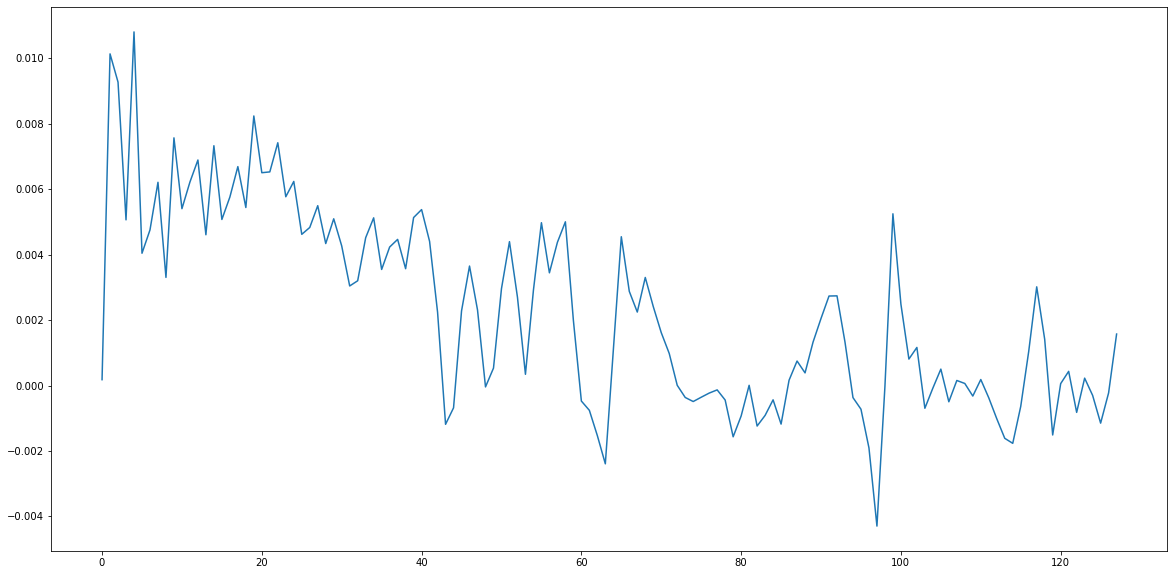

In [31]:
# a single record in the intertial folder
some_file.iloc[0].plot();

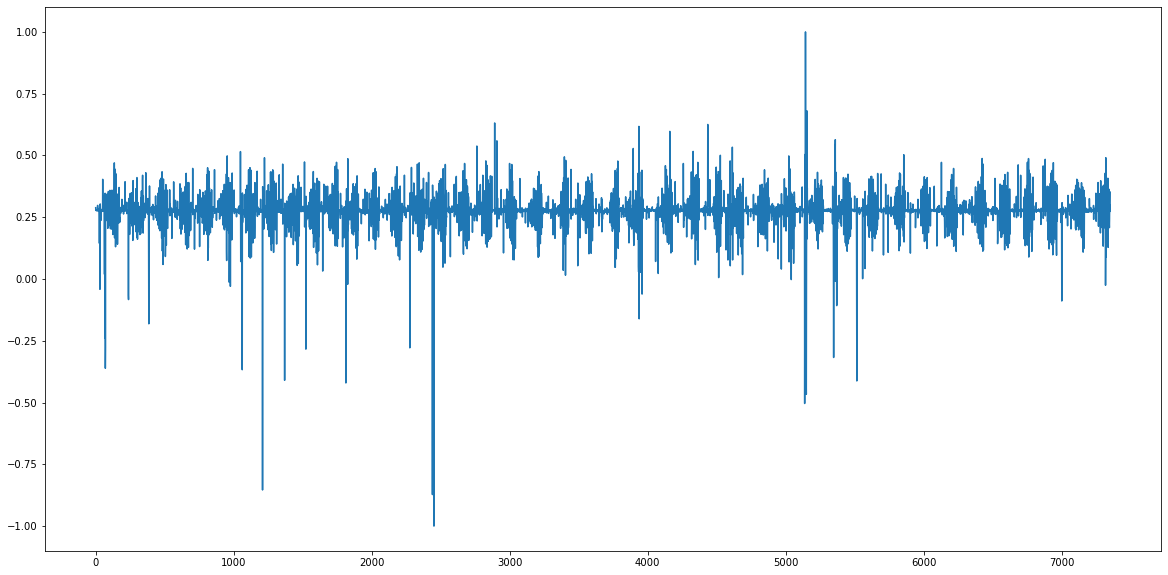

In [32]:
# a single column in the Xtrain file
Xtrain.iloc[:, 0].plot();

### 🤩 Are you feeling something about the N x T x D now?
It looks like we are looking at the data from multiple dimensions. **Nah.** We're not.

- **Inertial Signals** are the collection of the **original** signals (of course the preprocessed but the simple, straingt signals.) 
- That means, whatever we have in the `x_train` or in `x_test` with 561 features are the **result** of feature engineering on the straight **intertial signals**!!
- Thus, we have 2 options:
    1. Either use the **ready** feature engineered file.
    2. Use the raw signals from the intertial signals folder.
- Note that inertial signals folder has `9` files. So, `x`, `y` and `z` from gyroscore and accelerometer *(and another one from body acceleration, as we have calculated above)*.

> To make this project fun and understandable, we are going to use the files from the "inertial signals" folder and make the dataset from ground up. 

We have the following files to combine:

In [33]:
!ls "../data/UCI-HAR/UCI HAR Dataset/train/Inertial Signals"

body_acc_x_train.txt
body_acc_y_train.txt
body_acc_z_train.txt
body_gyro_x_train.txt
body_gyro_y_train.txt
body_gyro_z_train.txt
total_acc_x_train.txt
total_acc_y_train.txt
total_acc_z_train.txt


Which will look like...

<img src="../images/data-viz.jpg" height=400 width=400>

For both, *train* and *test*.
___
Let's code that out!

👉 Number of records in training!

In [34]:
!wc -l "../data/UCI-HAR/UCI HAR Dataset/train/Inertial Signals/body_acc_x_train.txt"

7352 ../data/UCI-HAR/UCI HAR Dataset/train/Inertial Signals/body_acc_x_train.txt


👉 Number of records in testing!

In [36]:
!wc -l "../data/UCI-HAR/UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt"

2947 ../data/UCI-HAR/UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt


In [37]:
# loading all 9 files and storing them in the array for easy access!
Ntrain = 7352
Ntest = 2947
T = 128
D = 9

Great. Now, let's make the **empty** arrays where the data will be stored.

In [39]:
train = np.zeros(shape=(Ntrain, T, D))
test = np.zeros(shape=(Ntest, T, D))

Now, let's start storing!

In [48]:
# for training
path = "../data/UCI-HAR/UCI HAR Dataset/train/Inertial Signals/"
for Dth, file in enumerate(os.listdir(path=path)):
    data = pd.read_csv(path+file, 
                       header=None,
                       delim_whitespace=True).values
    train[:, :, Dth] = data
    print("Reading & Storing Successful for D =", Dth)

Reading & Storing Successful for D = 0
Reading & Storing Successful for D = 1
Reading & Storing Successful for D = 2
Reading & Storing Successful for D = 3
Reading & Storing Successful for D = 4
Reading & Storing Successful for D = 5
Reading & Storing Successful for D = 6
Reading & Storing Successful for D = 7
Reading & Storing Successful for D = 8


In [51]:
# for testing
path = "../data/UCI-HAR/UCI HAR Dataset/test/Inertial Signals/"
for Dth, file in enumerate(os.listdir(path=path)):
    data = pd.read_csv(path+file, 
                       header=None,
                       delim_whitespace=True).values
    test[:, :, Dth] = data
    print("Reading & Storing Successful for D =", Dth)

Reading & Storing Successful for D = 0
Reading & Storing Successful for D = 1
Reading & Storing Successful for D = 2
Reading & Storing Successful for D = 3
Reading & Storing Successful for D = 4
Reading & Storing Successful for D = 5
Reading & Storing Successful for D = 6
Reading & Storing Successful for D = 7
Reading & Storing Successful for D = 8


In [54]:
train.shape

(7352, 128, 9)

In [55]:
test.shape

(2947, 128, 9)

### 🆒 

#### Did we just forget our `y`?

In [62]:
ytrain = pd.read_csv("../data/UCI-HAR/UCI HAR Dataset/train/y_train.txt", header=None).values.flatten()
ytest = pd.read_csv("../data/UCI-HAR/UCI HAR Dataset/test/y_test.txt", header=None).values.flatten()

In [63]:
ytrain

array([5, 5, 5, ..., 2, 2, 2], dtype=int64)

In [64]:
ytrain.shape

(7352,)

### 🆒 

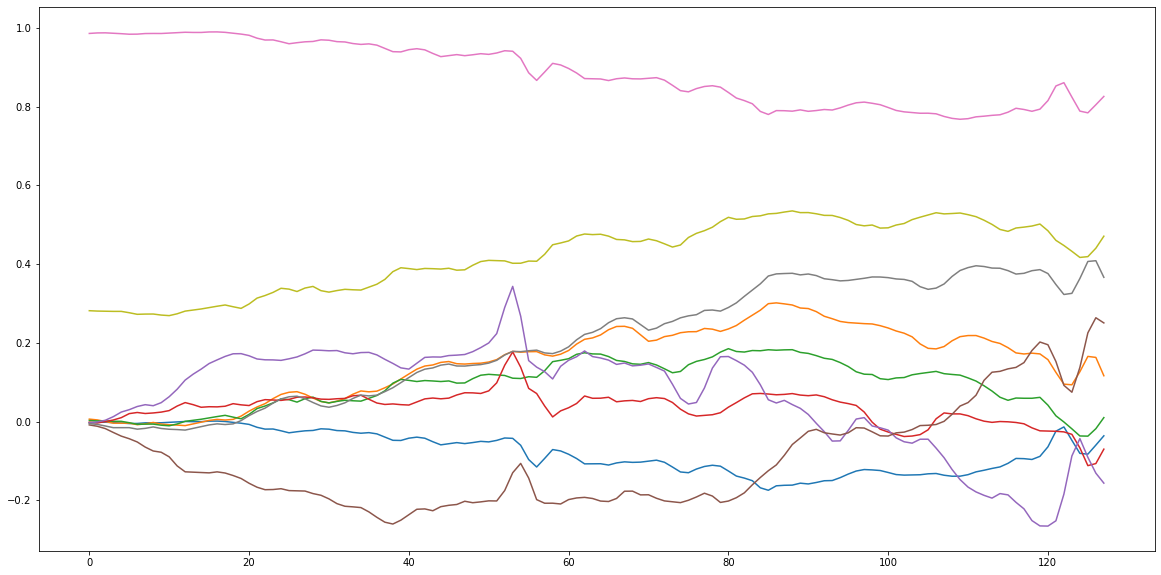

In [87]:
# this is how `1` person's data looks like 
# for all 9 sensors.
plt.plot(train[7000, :, :]);

Here, we are plotting: 

<img src="../images/all-sensors.jpg" height=300 width=300>

*Used 7000th person because in the course, the author uses the same number. I have tried different numbers like 123, 1212, 999... but those persons are not showing a good chart like this. Hats off to the author for bringing this 7000th person with this clear view.*

# 

# Model Building

<p align="center">
<img src="../images/neural_net.jpg" height=500 width=300 alt="https://process.studio">
</p> 

Now, we will start making the *multi tailed neural network* and that for *each D*.

In [96]:
# to store input layers
input_layers = []

# to store the last hidden layers
last_hidden_layers = []

for i in range(D):
    input_layer = Input(shape=(T,))
    hidden_layer = Dense(64, activation="relu")(input_layer)
    hidden_layer = Dense(32, activation="relu")(hidden_layer)
    
    input_layers.append(input_layer)
    last_hidden_layers.append(hidden_layer)

Till now, we have the **left side** of the all `9` neural network ready. The right side of **concatination** and the **final output** layer is still remaining.

In [97]:
len(last_hidden_layers)

9

In [100]:
fully_concatinated_layer = Concatenate()(last_hidden_layers)

In [101]:
fully_concatinated_layer

<KerasTensor: shape=(None, 288) dtype=float32 (created by layer 'concatenate_2')>

In [102]:
32 * 9

288

See that number `288`? <br>
That means, the last hidden_layer of 32 nodes for all 9 neural network have been concatenated and have made a **single major** layer with `288` nodes. Simple calculation!

In [104]:
# the number of classes
n_classes = 6
output_layer = Dense(n_classes, activation="softmax")(fully_concatinated_layer)
model = Model(input_layers, output_layer)

In [105]:
model

Now, finally the model is **ready** 🤘